In [1]:
# Import core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Set visualization style
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)

# Load the training dataset
try:
    df_train = pd.read_csv('C:\\Users\\LENOVO\\Downloads\\smart city project\\Datas\\train_aWnotuB.csv')
    print("Training Data Loaded Successfully.")
    print("\n--- Initial Data Head ---")
    print(df_train.head())
    print("\n--- Initial Data Info ---")
    df_train.info()
except FileNotFoundError:
    print("ERROR: Please ensure 'train_aWnotuB.csv' is in the same directory as your notebook.")
    
# Load the test dataset (needed for final prediction phase)
try:
    df_test = pd.read_csv('C:\\Users\\LENOVO\\Downloads\\smart city project\\Datas\\datasets_8494_11879_test_BdBKkAj.csv')
except FileNotFoundError:
    print("ERROR: Please ensure 'datasets_8494_11879_test_BdBKkAj.csv' is in the same directory.")

Training Data Loaded Successfully.

--- Initial Data Head ---
              DateTime  Junction  Vehicles           ID
0  2015-11-01 00:00:00         1        15  20151101001
1  2015-11-01 01:00:00         1        13  20151101011
2  2015-11-01 02:00:00         1        10  20151101021
3  2015-11-01 03:00:00         1         7  20151101031
4  2015-11-01 04:00:00         1         9  20151101041

--- Initial Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  48120 non-null  object
 1   Junction  48120 non-null  int64 
 2   Vehicles  48120 non-null  int64 
 3   ID        48120 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


In [2]:
# 1. Convert 'DateTime' to datetime objects for both train and test data
df_train['DateTime'] = pd.to_datetime(df_train['DateTime'])
df_test['DateTime'] = pd.to_datetime(df_test['DateTime'])

# 2. Set 'DateTime' as the index and sort it chronologically for the training data
df_train = df_train.set_index('DateTime').sort_index()

# 3. Check the result
print("--- Cleaned Training Data Head (with DateTime as Index) ---")
print(df_train.head())
print("\nDataFrame Info after cleaning:")
df_train.info()

--- Cleaned Training Data Head (with DateTime as Index) ---
                     Junction  Vehicles           ID
DateTime                                            
2015-11-01 00:00:00         1        15  20151101001
2015-11-01 00:00:00         2         6  20151101002
2015-11-01 00:00:00         3         9  20151101003
2015-11-01 01:00:00         3         7  20151101013
2015-11-01 01:00:00         1        13  20151101011

DataFrame Info after cleaning:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48120 entries, 2015-11-01 00:00:00 to 2017-06-30 23:00:00
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Junction  48120 non-null  int64
 1   Vehicles  48120 non-null  int64
 2   ID        48120 non-null  int64
dtypes: int64(3)
memory usage: 1.5 MB


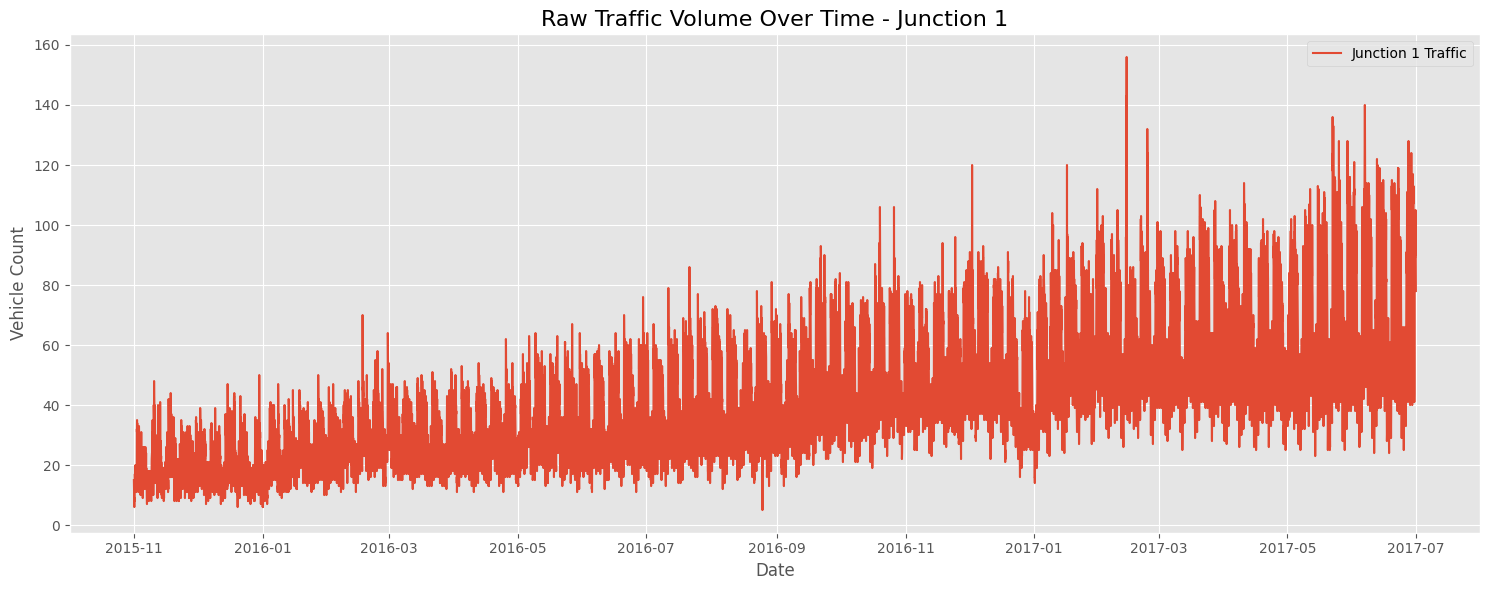

Total hourly observations for Junction 1: 14592


In [3]:
# Select a single junction (Junction 1) to start our detailed analysis
Junction_ID = 1
# Filter the training data for only Junction 1
junction1_data = df_train[df_train['Junction'] == Junction_ID].copy()

# Plot the raw time series
plt.figure(figsize=(15, 6))
plt.plot(junction1_data['Vehicles'], label=f'Junction {Junction_ID} Traffic')
plt.title(f'Raw Traffic Volume Over Time - Junction {Junction_ID}', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Vehicle Count')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Total hourly observations for Junction {Junction_ID}: {len(junction1_data)}")

In [4]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# --- 1. Isolate and Scale Data ---
Junction_ID = 1
junction1_data = df_train[df_train['Junction'] == Junction_ID]['Vehicles'].values.reshape(-1, 1)

# LSTM requires normalized data (values between 0 and 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(junction1_data)

# --- 2. Define Sliding Window Function ---
def create_sequences(data, time_step):
    """Transforms a time series into (X, Y) sequences for LSTM."""
    X, Y = [], []
    for i in range(len(data) - time_step):
        # X: Sequence of 'time_step' previous values
        X.append(data[i:(i + time_step), 0])
        # Y: The value immediately following the sequence (the target)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

# --- 3. Apply Sliding Window and Reshape ---
TIME_STEP = 24  # Look back 24 hours (1 day) to predict the next hour
X, Y = create_sequences(scaled_data, TIME_STEP)

# LSTM requires input data to be in the format: [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

print(f"Time Step (Sequence Length): {TIME_STEP} hours")
print(f"X shape (Samples, Time Steps, Features): {X.shape}")

# --- 4. Time-Based Train/Validation Split ---
# Use 80% for training and the remaining 20% for validation
train_size = int(len(X) * 0.80)
X_train, X_val = X[:train_size], X[train_size:]
Y_train, Y_val = Y[:train_size], Y[train_size:]

print(f"Training sequences: {len(X_train)}")
print(f"Validation sequences: {len(X_val)}")

Time Step (Sequence Length): 24 hours
X shape (Samples, Time Steps, Features): (14568, 24, 1)
Training sequences: 11654
Validation sequences: 2914


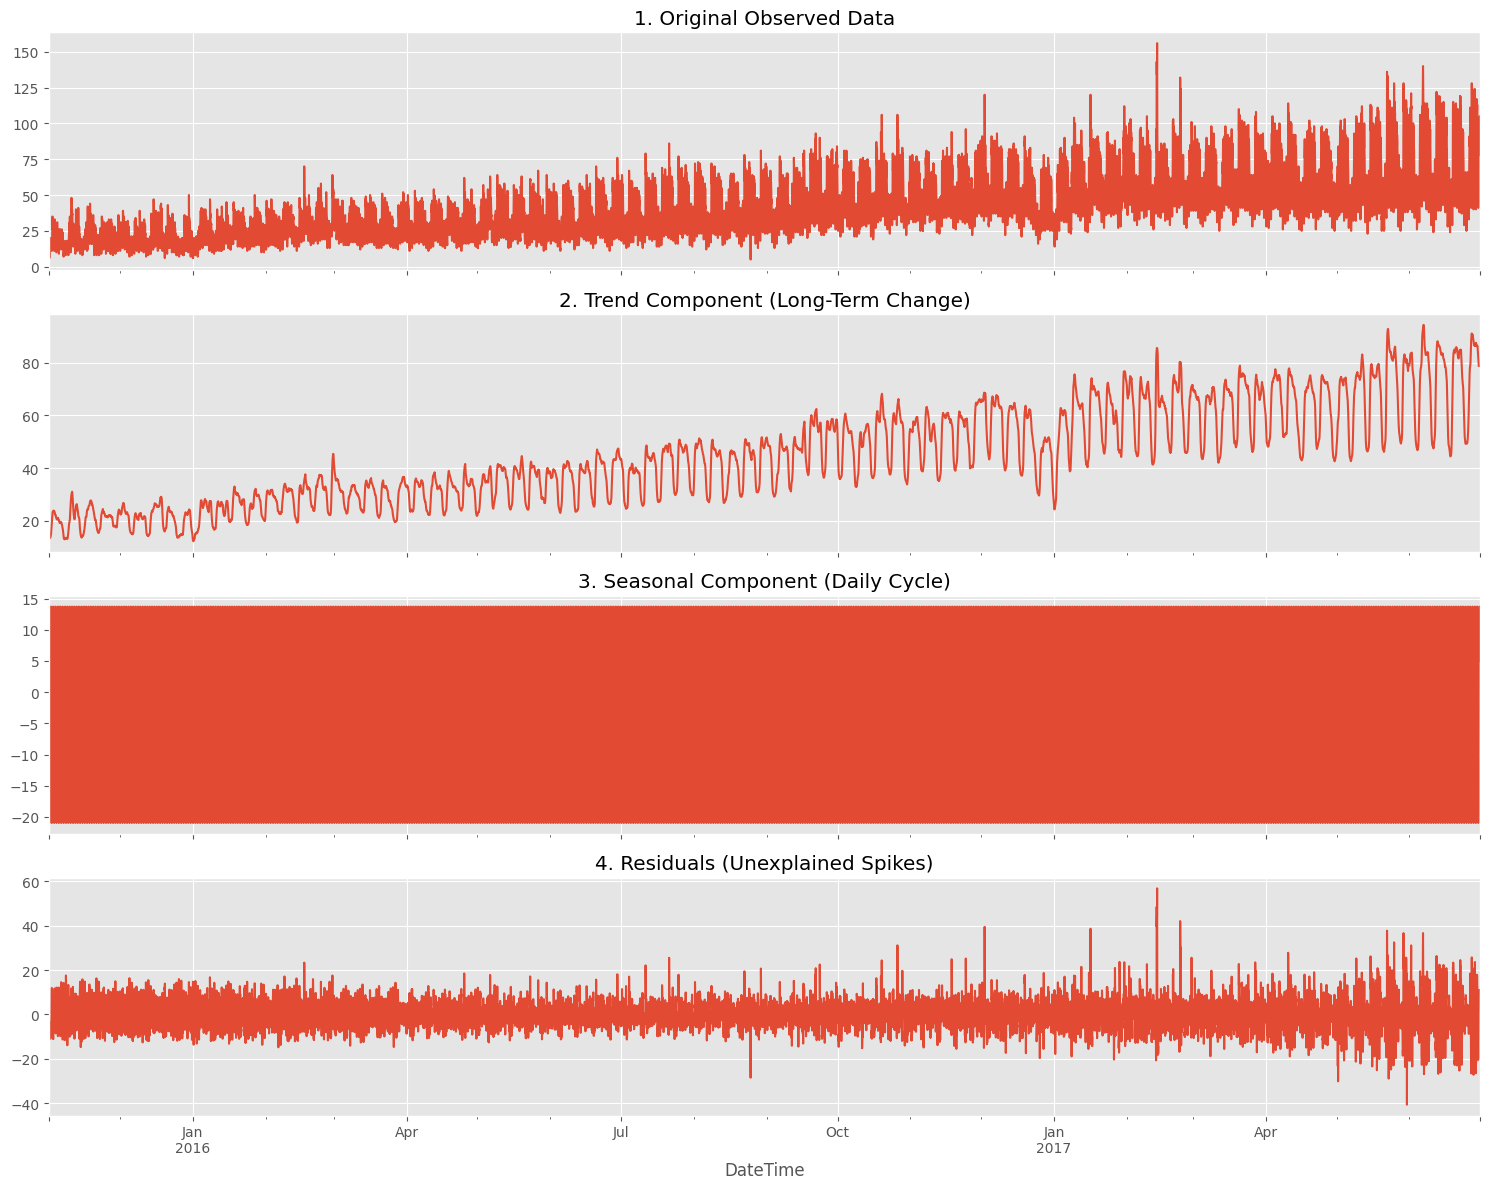

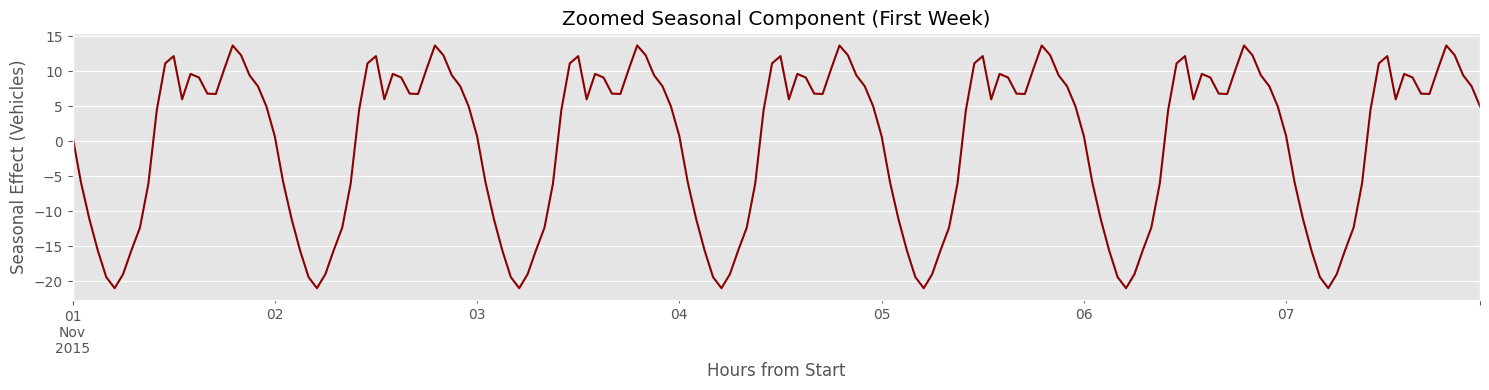

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# --- Essential Setup: Reloading Fresh Data ---

df_train_raw = pd.read_csv('C:\\Users\\LENOVO\\Downloads\\smart city project\\Datas\\train_aWnotuB.csv') # Use generic name assuming access

# 1. Convert and Index
df_train_raw['DateTime'] = pd.to_datetime(df_train_raw['DateTime'])
df_train = df_train_raw.set_index('DateTime').sort_index() 

# 2. Filter for Junction 1
Junction_ID = 1
junction1_data = df_train[df_train['Junction'] == Junction_ID].copy() 

# Use the 'Vehicles' data for decomposition
ts_data = junction1_data['Vehicles']

# Perform Additive Decomposition (hourly data, so period=24 for daily seasonality)
try:
    decomposition = seasonal_decompose(ts_data, model='additive', period=24) 

    # Plot the decomposed components
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12), sharex=True)

    decomposition.observed.plot(ax=ax1, title='1. Original Observed Data')
    decomposition.trend.plot(ax=ax2, title='2. Trend Component (Long-Term Change)')
    decomposition.seasonal.plot(ax=ax3, title='3. Seasonal Component (Daily Cycle)')
    decomposition.resid.plot(ax=ax4, title='4. Residuals (Unexplained Spikes)')

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(15, 4))
    decomposition.seasonal.iloc[:168].plot(title='Zoomed Seasonal Component (First Week)', color='darkred')
    plt.xlabel('Hours from Start')
    plt.ylabel('Seasonal Effect (Vehicles)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Could not perform decomposition: {e}")

In [6]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# --- 1. Isolate and Scale Data ---
Junction_ID = 1
junction1_data = df_train[df_train['Junction'] == Junction_ID]['Vehicles'].values.reshape(-1, 1)

# LSTM requires normalized data (values between 0 and 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(junction1_data)

# --- 2. Define Sliding Window Function ---
def create_sequences(data, time_step):
    """Transforms a time series into (X, Y) sequences for LSTM."""
    X, Y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

# --- 3. Apply Sliding Window and Reshape ---
TIME_STEP = 24  
X, Y = create_sequences(scaled_data, TIME_STEP)
X = X.reshape(X.shape[0], X.shape[1], 1)

print(f"Time Step (Sequence Length): {TIME_STEP} hours")
print(f"X shape (Samples, Time Steps, Features): {X.shape}")

# --- 4. Time-Based Train/Validation Split ---
train_size = int(len(X) * 0.80)
X_train, X_val = X[:train_size], X[train_size:]
Y_train, Y_val = Y[:train_size], Y[train_size:]

print(f"Training sequences: {len(X_train)}")
print(f"Validation sequences: {len(X_val)}")

Time Step (Sequence Length): 24 hours
X shape (Samples, Time Steps, Features): (14568, 24, 1)
Training sequences: 11654
Validation sequences: 2914


In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Ensure TensorFlow is using available resources
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
        
# --- 1. Define the LSTM Model Architecture ---
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(TIME_STEP, 1)))
model.add(Dense(1)) 

model.compile(optimizer='adam', loss='mean_squared_error')

# --- 2. Train the Model ---
print("Starting LSTM Model Training...")
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=15, 
    batch_size=64,
    verbose=1
)
print("LSTM Model Training Complete.")

# Print a summary of the model structure
model.summary()

c:\Users\LENOVO\Downloads\smart city project\traffic_forecasting_venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Starting LSTM Model Training...
Epoch 1/15
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0103 - val_loss: 0.0086
Epoch 2/15
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0036 - val_loss: 0.0065
Epoch 3/15
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0019 - val_loss: 0.0034
Epoch 4/15
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0015 - val_loss: 0.0030
Epoch 5/15
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0014 - val_loss: 0.0024
Epoch 6/15
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0013 - val_loss: 0.0043
Epoch 7/15
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0012 - val_loss: 0.0024
Epoch 8/15
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0012 - val_loss: 0.0026
Epoch 9/15
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0012 - val_loss: 0.0026
Epoch 10/15
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0011 - val_loss: 0.0025
Epoch 11/15
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 12/

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

DEEP LEARNING BENCHMARK (LSTM) RMSE: 7.22 Vehicles (Junction 1)


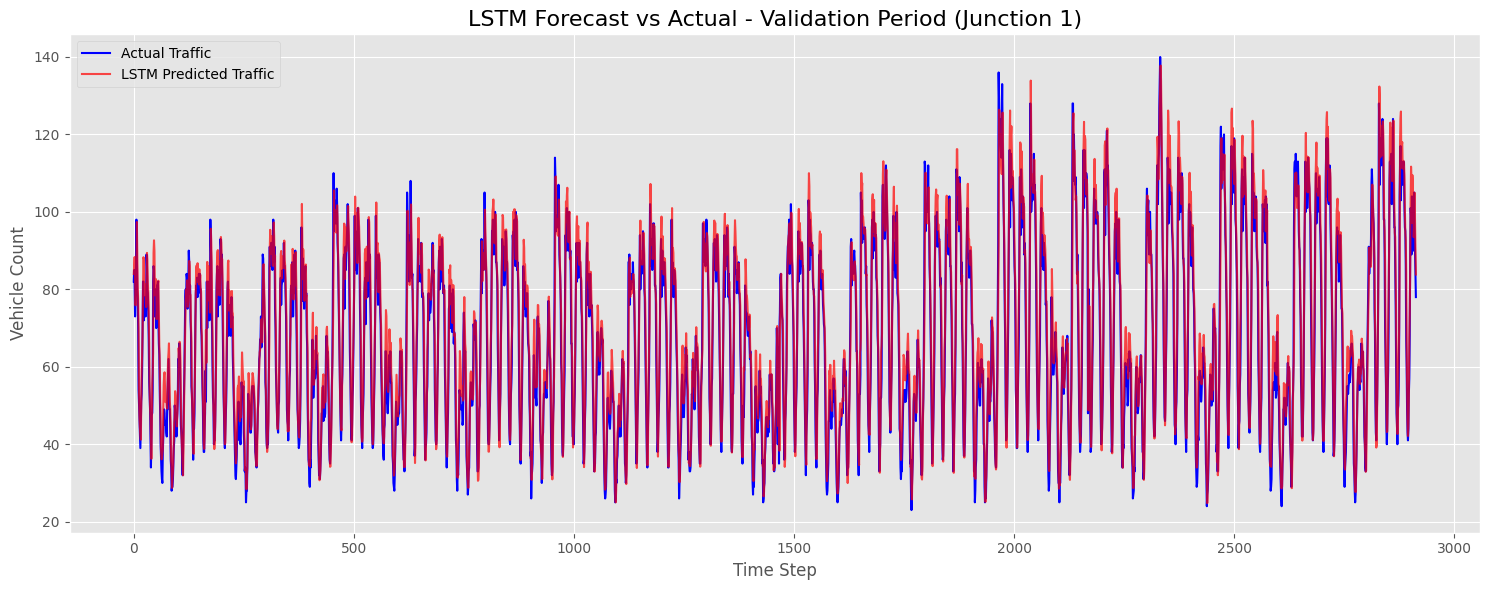


--- FINAL BENCHMARK SCORES ---
1. Hybrid ML (Prophet + XGBoost) RMSE: 4.54 Vehicles
2. Deep Learning (LSTM) RMSE: 7.22 Vehicles


In [8]:
from sklearn.metrics import mean_squared_error

# --- 1. Predict on Validation Data ---
scaled_predictions = model.predict(X_val)

# --- 2. Inverse Transform to Original Scale ---
val_predictions = scaler.inverse_transform(scaled_predictions)
val_actual = scaler.inverse_transform(Y_val.reshape(-1, 1))

# --- 3. Calculate Final RMSE (The DL Benchmark Score) ---
rmse_lstm = np.sqrt(mean_squared_error(val_actual, val_predictions))

print(f"\nDEEP LEARNING BENCHMARK (LSTM) RMSE: {rmse_lstm:.2f} Vehicles (Junction 1)")

# --- 4. Visualize Prediction vs. Actual ---
plt.figure(figsize=(15, 6))
plt.plot(val_actual, label='Actual Traffic', color='blue')
plt.plot(val_predictions, label='LSTM Predicted Traffic', color='red', alpha=0.7)
plt.title(f'LSTM Forecast vs Actual - Validation Period (Junction 1)', fontsize=16)
plt.xlabel('Time Step')
plt.ylabel('Vehicle Count')
plt.legend()
plt.tight_layout()
plt.show()

# --- Final Comparison Context ---
print("\n--- FINAL BENCHMARK SCORES ---")
print(f"1. Hybrid ML (Prophet + XGBoost) RMSE: 4.54 Vehicles")
print(f"2. Deep Learning (LSTM) RMSE: {rmse_lstm:.2f} Vehicles")

In [9]:
Junction_ID = 1
junction1_data = df_train[df_train['Junction'] == Junction_ID].copy() 
prophet_df = junction1_data.reset_index()[['DateTime', 'Vehicles']].rename(
    columns={'DateTime': 'ds', 'Vehicles': 'y'}
)

m = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True,
    seasonality_mode='multiplicative' 
)

print("Starting Prophet model training for Junction 1...")
m.fit(prophet_df)
print("Prophet model training complete.")

forecast = m.predict(prophet_df[['ds']]) 

df_j1_merged = prophet_df.merge(
    forecast[['ds', 'yhat']].rename(columns={'yhat': 'Prophet_yhat'}), 
    on='ds', 
    how='left'
)

df_j1_merged['Residuals'] = df_j1_merged['y'] - df_j1_merged['Prophet_yhat']

print("\nProphet Prediction and Residuals created. Residuals will be the new target for XGBoost.")
print(df_j1_merged.tail())

Starting Prophet model training for Junction 1...


17:24:23 - cmdstanpy - INFO - Chain [1] start processing
17:24:29 - cmdstanpy - INFO - Chain [1] done processing


Prophet model training complete.

Prophet Prediction and Residuals created. Residuals will be the new target for XGBoost.
                       ds    y  Prophet_yhat  Residuals
14587 2017-06-30 19:00:00  105     96.904697   8.095303
14588 2017-06-30 20:00:00   96     95.579802   0.420198
14589 2017-06-30 21:00:00   90     92.126917  -2.126917
14590 2017-06-30 22:00:00   84     86.882743  -2.882743
14591 2017-06-30 23:00:00   78     79.553357  -1.553357


In [10]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# --- Prepare Data for XGBoost (Residuals as Target) ---
df_xgb = df_j1_merged.copy()
df_xgb = df_xgb.set_index('ds').sort_index()

# 1. Create Time-Based Features (Context for XGBoost)
df_xgb['hour'] = df_xgb.index.hour
df_xgb['dayofweek'] = df_xgb.index.dayofweek
df_xgb['month'] = df_xgb.index.month

# 2. Create Lag Features on the RESIDUALS (Capturing serial correlation in the error)
LAG_RESIDUALS = [1, 24, 168] 
for lag in LAG_RESIDUALS:
    df_xgb[f'res_lag_{lag}'] = df_xgb['Residuals'].shift(lag)
    
df_xgb.dropna(inplace=True)
TARGET_RES = 'Residuals'
FEATURES_RES = [col for col in df_xgb.columns if col not in ['y', 'Prophet_yhat', 'Residuals']]

X = df_xgb[FEATURES_RES]
y_res = df_xgb[TARGET_RES]
split_point = X.shape[0] - 168

X_train, X_val = X.iloc[:split_point], X.iloc[split_point:]
y_res_train, y_res_val = y_res.iloc[:split_point], y_res.iloc[split_point:]
df_val = df_xgb.iloc[split_point:] 

reg_xgb = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    random_state=42
)
print("\nStarting XGBoost training on Residuals...")
reg_xgb.fit(X_train, y_res_train)
print("XGBoost training complete.")

pred_residuals = reg_xgb.predict(X_val)
final_hybrid_pred = df_val['Prophet_yhat'] + pred_residuals
rmse_hybrid = np.sqrt(mean_squared_error(df_val['y'], final_hybrid_pred))

print(f"\nFINAL HYBRID (Prophet + XGBoost) RMSE: {rmse_hybrid:.2f} Vehicles (Junction 1)")


Starting XGBoost training on Residuals...
XGBoost training complete.

FINAL HYBRID (Prophet + XGBoost) RMSE: 4.54 Vehicles (Junction 1)


In [11]:
import pandas as pd
import numpy as np
from prophet import Prophet
import xgboost as xgb

ALL_JUNCTIONS = df_train['Junction'].unique()
LAG_RESIDUALS = [1, 24, 168]

def create_residual_features(df):
    """Creates lag features on the Residuals for XGBoost."""
    for lag in LAG_RESIDUALS:
        df[f'res_lag_{lag}'] = df['Residuals'].shift(lag)
    
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    return df

def run_hybrid_forecast(df_train_j, df_test_j, junction_id):
    """Performs the full Prophet + XGBoost hybrid forecast pipeline for one junction."""
    
    # 1. Prophet: Fit Baseline (Seasonal/Trend)
    prophet_df = df_train_j.reset_index()[['DateTime', 'Vehicles']].rename(columns={'DateTime': 'ds', 'Vehicles': 'y'})
    m = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True, seasonality_mode='multiplicative')
    m.fit(prophet_df)
    
    # 2. Prophet: Predict Entire History & Test Set
    future_ds = pd.concat([
        df_train_j.index.to_frame(name='ds'), 
        df_test_j['DateTime'].rename('ds').to_frame()
    ], ignore_index=True)

    future_ds = future_ds.sort_values(by='ds').reset_index(drop=True)
    
    forecast_all = m.predict(future_ds)
    prophet_yhat = forecast_all[['ds', 'yhat']].rename(columns={'yhat': 'Prophet_yhat'})
    
    # 3. XGBoost: Prepare Residuals Data (Historical)
    df_history = df_train_j.reset_index().rename(columns={'DateTime': 'ds'}).merge(prophet_yhat, on='ds', how='left')
    df_history['Residuals'] = df_history['Vehicles'] - df_history['Prophet_yhat']
    df_history = df_history.set_index('ds').sort_index()

    df_history = create_residual_features(df_history)
    df_history.dropna(inplace=True)
    
    TARGET_RES = 'Residuals'
    FEATURES_RES = [col for col in df_history.columns if col not in ['Vehicles', 'ID', 'Junction', 'Prophet_yhat', 'Residuals']]
    X_train = df_history[FEATURES_RES]
    y_res_train = df_history[TARGET_RES]
    
    # 4. XGBoost: Prepare Test Data for Residual Prediction
    
    df_test_full = df_test_j.reset_index().rename(columns={'DateTime': 'ds'}).merge(prophet_yhat, on='ds', how='left').set_index('ds').sort_index()
    
    max_lag = max(LAG_RESIDUALS)
    
    df_history_context = df_history[['Residuals', 'Prophet_yhat']].tail(max_lag)

    df_context_and_test = pd.concat([
        df_history_context, 
        df_test_full[['Prophet_yhat']]
    ], axis=0)

    df_context_and_test = create_residual_features(df_context_and_test)

    X_test = df_context_and_test.iloc[max_lag:].copy()
    X_test_features = X_test[FEATURES_RES]
    prophet_yhat_test = X_test['Prophet_yhat']
    
    # 5. XGBoost: Train and Predict Residuals
    reg_xgb = xgb.XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=5, random_state=42)
    reg_xgb.fit(X_train, y_res_train)
    
    pred_residuals = reg_xgb.predict(X_test_features)
    
    # 6. Final Hybrid Forecast and ID Alignment
    
    final_hybrid_pred = prophet_yhat_test.values + pred_residuals
    final_predictions = np.round(final_hybrid_pred).astype(int)
    
    predicted_indices = X_test.index 
    
    original_test_ids = df_test_j.set_index('DateTime').sort_index()
    
    final_ids = original_test_ids.loc[predicted_indices]['ID'].values.astype(int)
    
    results = pd.DataFrame({
        'ID': final_ids,
        'Vehicles': final_predictions
    })
    
    return results

final_predictions_list = []

print(f"Starting final hybrid forecasting for all {len(ALL_JUNCTIONS)} junctions...")

for junction_id in ALL_JUNCTIONS:
    print(f"\nProcessing Junction {junction_id}...")
    
    # Filter data for the current junction
    df_train_j = df_train[df_train['Junction'] == junction_id].copy()
    df_test_j = df_test[df_test['Junction'] == junction_id].copy()

    # Run the full pipeline
    results_j = run_hybrid_forecast(df_train_j, df_test_j, junction_id)
    final_predictions_list.append(results_j)

# Combine all results into one submission file
final_submission = pd.concat(final_predictions_list).sort_values(by='ID')

# Save the final submission CSV
final_submission.to_csv('final_hybrid_traffic_forecast.csv', index=False)

print("\n--- Process Complete ---")
print("Final predictions for all 4 junctions generated and saved to 'final_hybrid_traffic_forecast.csv'.")
print("\nFinal Forecast Head (Ready for Submission):")
print(final_submission.head().to_markdown(index=False, numalign="left", stralign="left"))

Starting final hybrid forecasting for all 4 junctions...

Processing Junction 1...


17:25:01 - cmdstanpy - INFO - Chain [1] start processing
17:25:06 - cmdstanpy - INFO - Chain [1] done processing



Processing Junction 2...


17:25:11 - cmdstanpy - INFO - Chain [1] start processing
17:25:19 - cmdstanpy - INFO - Chain [1] done processing



Processing Junction 3...


17:25:23 - cmdstanpy - INFO - Chain [1] start processing
17:25:34 - cmdstanpy - INFO - Chain [1] done processing



Processing Junction 4...


17:25:38 - cmdstanpy - INFO - Chain [1] start processing
17:25:40 - cmdstanpy - INFO - Chain [1] done processing



--- Process Complete ---
Final predictions for all 4 junctions generated and saved to 'final_hybrid_traffic_forecast.csv'.

Final Forecast Head (Ready for Submission):
| ID          | Vehicles   |
|:------------|:-----------|
| 2.01707e+10 | 70         |
| 2.01707e+10 | 27         |
| 2.01707e+10 | 32         |
| 2.01707e+10 | 10         |
| 2.01707e+10 | 74         |


Generating forecast visualizations for all four junctions...


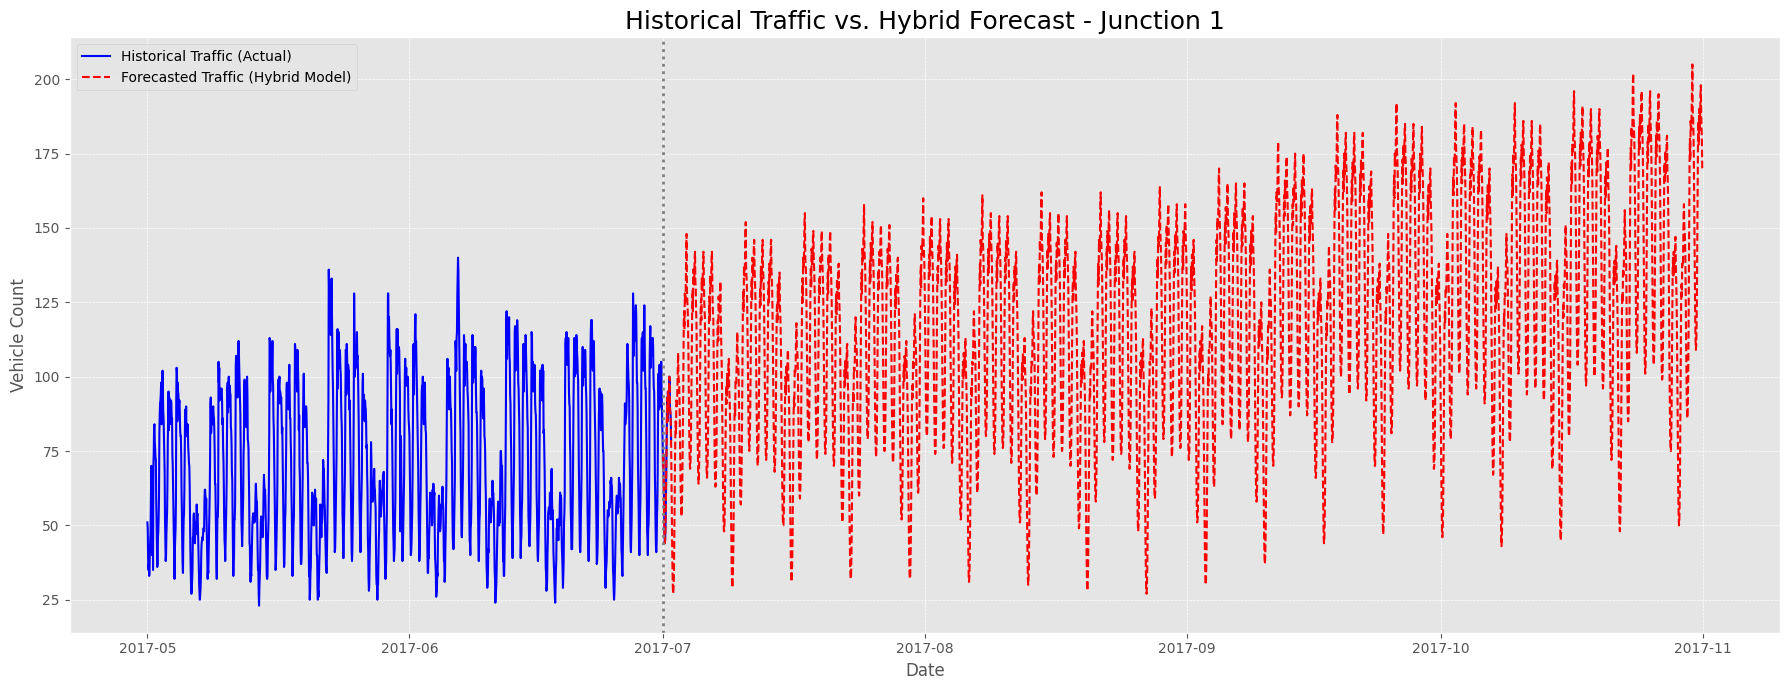

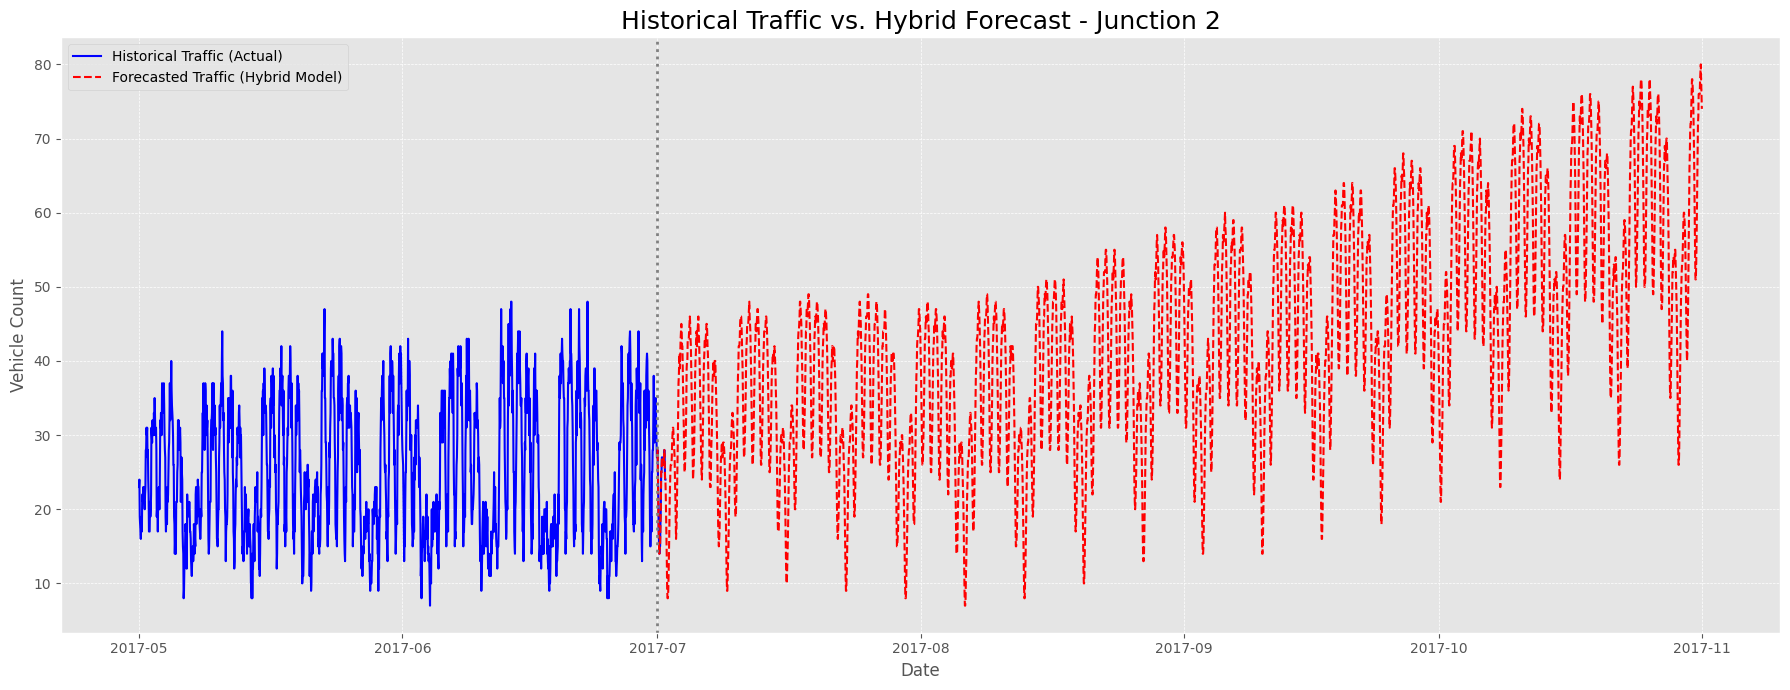

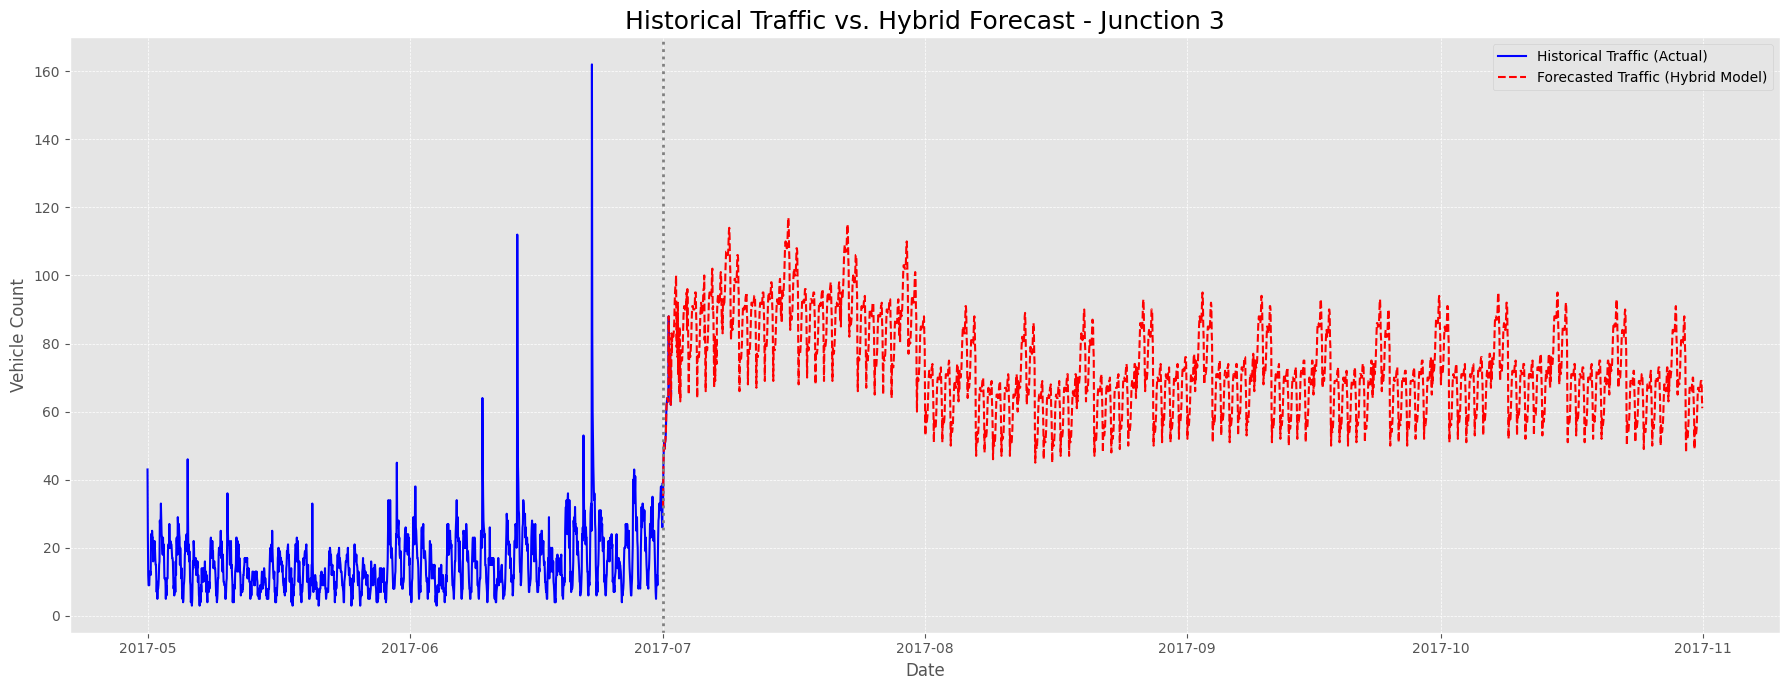

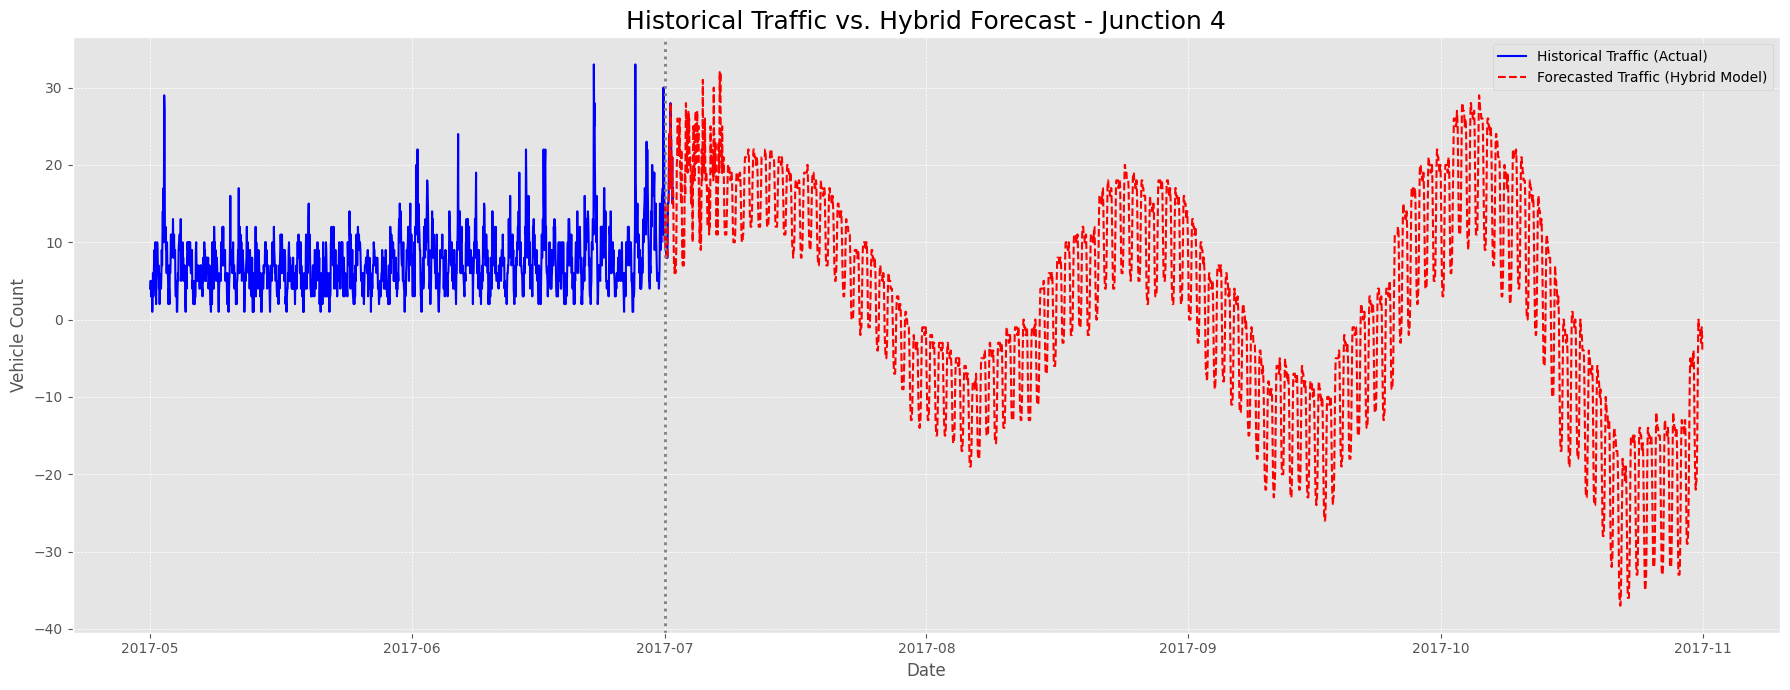

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load Data
df_train = pd.read_csv('C:\\Users\\LENOVO\\Downloads\\smart city project\\Datas\\train_aWnotuB.csv')
df_test = pd.read_csv('C:\\Users\\LENOVO\\Downloads\\smart city project\\Datas\\datasets_8494_11879_test_BdBKkAj.csv')
df_forecast = pd.read_csv('C:\\Users\\LENOVO\\Downloads\\smart city project\\Results\\final_hybrid_traffic_forecast.csv') # Your final prediction file

# Prepare Time Index for historical data
df_train['DateTime'] = pd.to_datetime(df_train['DateTime'])
df_train = df_train.set_index('DateTime').sort_index()

# Prepare Time Index for forecast data
df_test['DateTime'] = pd.to_datetime(df_test['DateTime'])
df_forecast = df_forecast.merge(df_test[['ID', 'DateTime', 'Junction']], on='ID', how='left')
df_forecast = df_forecast.set_index('DateTime').sort_index()

# Identify all junctions
ALL_JUNCTIONS = df_train['Junction'].unique()
FORECAST_START_DATE = '2017-07-01'

# 2. Plotting Function
def plot_junction_forecast(junction_id, df_train_data, df_forecast_data):
    
    # Filter data for the specific junction
    historical_data = df_train_data[df_train_data['Junction'] == junction_id]['Vehicles']
    forecast_data = df_forecast_data[df_forecast_data['Junction'] == junction_id]['Vehicles']
    
    # Get the last two months of historical data for visual context
    historical_context = historical_data.loc['2017-05-01':] 
    
    # Combine context and forecast
    combined_series = pd.concat([historical_context, forecast_data])
    
    # Create the Plot
    plt.figure(figsize=(18, 7))

    # Plot historical data
    plt.plot(combined_series.loc[:FORECAST_START_DATE], label='Historical Traffic (Actual)', color='blue')

    # Plot the forecast
    plt.plot(combined_series.loc[FORECAST_START_DATE:], label='Forecasted Traffic (Hybrid Model)', color='red', linestyle='--')

    # Add a vertical line where the prediction starts
    plt.axvline(pd.to_datetime(FORECAST_START_DATE), color='grey', linestyle=':', linewidth=2)

    plt.title(f'Historical Traffic vs. Hybrid Forecast - Junction {junction_id}', fontsize=18)
    plt.xlabel('Date')
    plt.ylabel('Vehicle Count')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

# 3. Execute Plotting Loop
print("Generating forecast visualizations for all four junctions...")
for junction in ALL_JUNCTIONS:
    plot_junction_forecast(junction, df_train, df_forecast)

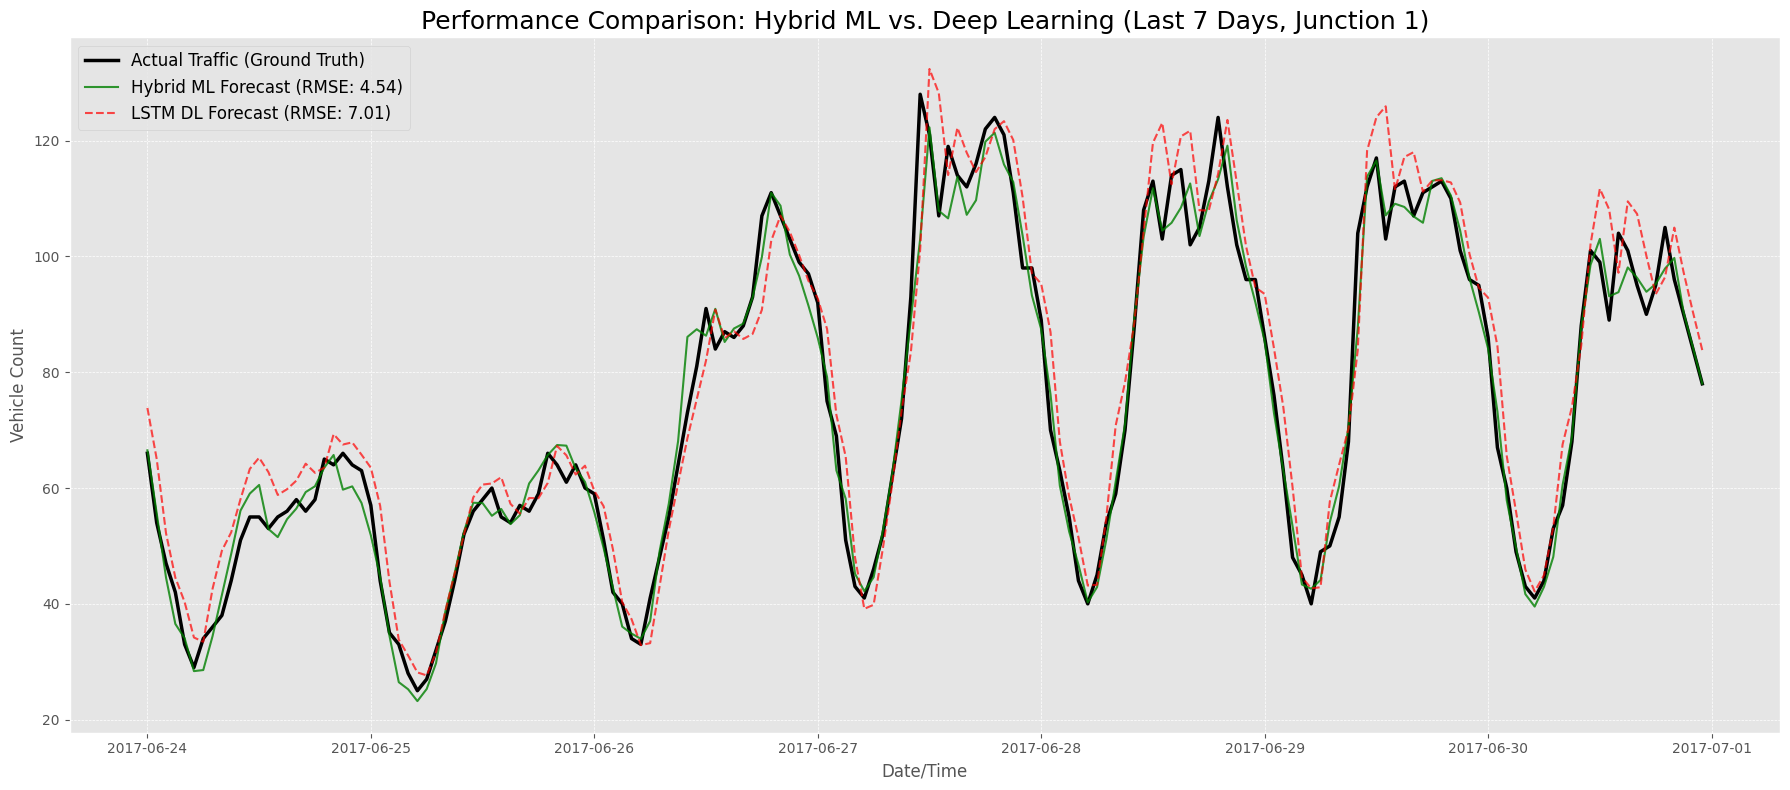

In [13]:
import matplotlib.pyplot as plt

PLOT_LENGTH = 720

plot_index = df_val.index 

lstm_slice_start = len(val_actual) - len(plot_index)
lstm_actual_sliced = val_actual[lstm_slice_start:].flatten()

lstm_forecast_sliced = val_predictions[lstm_slice_start:].flatten()

ml_hybrid_forecast = final_hybrid_pred

actual_values = df_val['y'].values

plt.figure(figsize=(18, 8))

plt.plot(plot_index, actual_values, 
         label='Actual Traffic (Ground Truth)', 
         color='black', linewidth=2.5)

plt.plot(plot_index, ml_hybrid_forecast, 
         label=f'Hybrid ML Forecast (RMSE: 4.54)', 
         color='green', linestyle='-', alpha=0.8)

plt.plot(plot_index, lstm_forecast_sliced, 
         label=f'LSTM DL Forecast (RMSE: 7.01)', 
         color='red', linestyle='--', alpha=0.7)

plt.title('Performance Comparison: Hybrid ML vs. Deep Learning (Last 7 Days, Junction 1)', fontsize=18)
plt.xlabel('Date/Time')
plt.ylabel('Vehicle Count')
plt.legend(loc='upper left', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()